In [1]:
!pip install pymorphy2

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

import html
import re
import nltk
from nltk import *
from nltk.probability import FreqDist
from collections import Counter

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
positive['class_label'] = [0] * len(positive)
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
negative['class_label'] = [1] * len(negative)
df = positive.append(negative)

In [4]:
df

,text,label,class_label
0,"@first_timee хоть я и школота, но поверь, у на...",positive,0
1,"Да, все-таки он немного похож на него. Но мой ...",positive,0
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,positive,0
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",positive,0
4,@irina_dyshkant Вот что значит страшилка :D\nН...,positive,0
...,...,...,...
111918,Но не каждый хочет что то исправлять:( http://...,negative,1
111919,скучаю так :-( только @taaannyaaa вправляет мо...,negative,1
111920,"Вот и в школу, в говно это идти уже надо(",negative,1
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",negative,1


In [3]:
emoticon_dict_rus = {
"!(^^)!": "придумал",
"))": "улыбка",
")))": "улыбка",
"))))": "улыбка",
")": "улыбка",
"':-)": "голова выбрита с одной стороны",
":)": "улыбка",
":-)": "улыбка",
";-)": "улыбка с подмигиванием",
"%-)": "смущение",
"( ^)t ... f(^ )": "дуэль",
"( ^_^)(^_^ )": "друзья",
"( ^_^)/": "привет",
"( ^_^)U---------U(^_^ )": "по телефону",
"( ´ ▽ ` )ﾉ": "наконец дома",
"( ﾟ▽ﾟ)/": "добрый вечер",
"(!_!)": "потрясение",
'("\(o_O)/")': "превед",
"(#^_^#)": "покраснел",
"($_$)": "жадность",
"(%_%)": "после ночи за компьютером",
"((((((^_^;)": "тихо убегаю",
"((+_+))": "uhmmmm",
"(*^.^*)": "возбуждён",
"(*^^*)": "смущение",
"(*^-^*)/": "привет!",
"(*^o^*)": "возбуждён",
"(*_*)": "восхищение",
"(-.-)Zzz..": "сон", 
"(.-.)": "стоим на голове",
"(//_-)": "скептик",
"(//_*)": "восторг",
"(//_^)": "радость",
"(//_о)": "удивление",
"(/_\)": "тает",
"(": "печаль",
"((": "печаль",
"(((": "печаль",
"((((": "печаль",
"(:-)": "рот до ушей",
"(;,,,;)": "Ктулху",
"(;_;)": "плач", 
"(;_;)/~~": "машущий рукой на прощание",
"(?_?)": "растерянность",
"(@_@)": "обалдение",
"(^)(*О_О*)": "поцелуй и удивление",
"(^)(^^)": "поцелуй",
"(^.^)": "женская улыбка",
"(^^ )3 ( ^^) ... (^^ )": "подслушал",
"(^^)": "вампир", 
"(^,,^)": "вампир",
"(^^')": "смущение",
"(^^;)": "смущение",
"(^_^)": "весёлый",
"(^_^)( ^_)( ^)( )(^ )(_^ )": "закрутился",
"(^_^)( ^_)( ^)( )(^ )(_^ )(@_@)": "закрутился до тошноты",
"(^_^)/": "привет",
"(^_^)/\(^_^)": "дай пять",
"(^_^)/~~": "привет",
"(^_^)V": "победа!",
"(^_^;)": "нервный смех",
"(^_^;;;)": "смущение",
"(^_^?)": "не понял",
"(^_^K^^)": "шептать",
"(^_____^)": "радость",
"(^_~)": "подмигивание",
"(-_^)": "подмигивание",
"(^0_0^)": "фыркающая свинка",
"(^L^)": "счастлив", 
"(^(^)": "счастлив",
"(^o^)": "смех",
"(^o^)/": "спасибо",
"(^o_o^)": "свинка",
"<3": "любовь",
"(-_(-_(-_-)_-)": "толпа",
"(-_-)": "грусть",
"(-_-;)": "болезнь",
"(+.+)(-.-)(_ _)": "упал без сил",
"(+_+)": "смерть",
"(=^_^=)": "кошка",
"(=_=)": "не спал ночью",
"(>.O)": "дали в глаз",
"(>_< )( >_<)": "сильное отрицание",
"(>_<)": "злой",
"(¬_¬)": "ага, конечно", 
"(8-о": "с похмелья",
"(D_D)i!i!i!i!i! (%_%)": "гипноз",
"(G_G)": "сильно утомлен",
"(L_L)": "ага, конечно",
"(Г_Г)": "ага, конечно",
"(O_O)": "удивление",
"(T_T)": "плач",
"(V_v)": "печаль",
"(V_v)": "неприятное удивление",
"(X_x)": "без башки",
"(о_О)": "офигеть",
"(о_о)": "удивление",
"(Т-Т)": "жалость",
"*:-)": "в колпаке Санта Клауса",
"*:о)": "клоун",
"*^_^*": "стеснение",
",-)": "подмигивающий одноглазый",
",:-)": "голова выбрита с другой стороны",
".-)": "одноглазый",
":-'": "сплёвывающий табак",
":-#": "молчание",
":-$": "рот на замок",
":-%": "банкир",
":-&": "лишившийся дара речи / смутившийся / косноязычный",
":-(": "печаль",
":'-(": "плач",
"-:-(": "неулыбающийся панк",
":(": "печаль", 
":'-(": "плач от горя",
"-:-)": "панк",
":'-)": "плач от счастья",
":-)_)": "смех",
":-)~": "валяющий дурака",
":-)D)": "смех",
":-)х": "галстук - бабочка",
":-*": "поцелуй",
":*)": "пьяный",
":**": "поцелуй",
":-*": "угрюмый",
":*": "поцелуй",
":-/": "скептик",
":-": "сплевыватель",
"::-)": "очкарик",
":-?": "курящий трубку",
":-@": "крик ужаса",
":-[": "злая усмешка",
":[": "неулыбающийся болван",
":-[": "вампир",
":[": "лодырь",
":-[": "неулыбающийся болван",
":-]": "сарказм",
":^": "нос сломан",
":_)": "нос соскользнул с лица",
":_0": "нос сдвинут с лица",
":-{)": "усатый",
":-{": "усатый",
":-{}": "девочка, красящая губы",
":-|": "безразличие",
":-}": "ирония",
":~(": "печаль",
":~)": "со сломанным носом",
":-~)": "замёрзший",
":-<": "печаль",
":=)": "два носа",
":->": "злая усмешка",
":-1": "нормально",
":-7": "кривая улыбка",
":-9": "облизываться",
":-c": "плохо",
":-C": "плохо",
":-D": "смех",
"D": "смех",
":D": "смех",
":DD": "смех",
":DDD": "смех",
":DDDD": "смех",
":DDDDD": "смех",
":DDDDDD": "смех",
"DD": "смех",
"DDD": "смех",
"DDDD": "смех",
"DDDDD": "смех",
"DDDDDD": "смех",
":-d": "насмешка",
":-E": "вампир с торчащими зубами",
":-F": "вампир с обломанным клыком",
":-i": "полуулыбка",
":-j": "улыбка",
":-k": "бейте меня!",
":n)": "забавно выглядящий нос",
":-o": "изумление",
":O": "громко говоит",
":-P": "показывает язык",
":-Q": "курящий",
":-q": "пытающийся достать языком до носа",
":-s": "непоследовательный, бессвязный",
":-S": "несогласованное утверждение",
":-t": "злой",
":u)": "забавно выглядящий нос",
":v)": "нос сломан в другом направлении",
":-v": "говорящая голова",
":-X": "запечатанные губы",
":Y": "зевает",
":-а": "пытающийся достать языком до носа",
":-Е": "клыкастый вампир",
":-е": "разочарование",
":о)": "клоун",
":-о": "ox-ox",
":-О": "не ори!", 
":-р": "показывает язык",
":-С": "лодырь",
":-х": "рот на замке",
";-(": "плач",
";-)": "подмигивание",
";->": "подмигивание",
"@%-D": "я не могу - я валяюсь!",
"@:-)": "в тюрбане",
"@^_^@": "в наушниках",
"@>,,X@": "дохлый вампир в наушниках, умер от меткого удара в глаз",
"[:-)": "в наушниках",
"\(^_^)/": "радость",
"\(^o\)(/o^)/": "еще одни танцульки",
"\(O_O)/": "удивление",
"\\(<.<|>.>)//": "оглядывается вокруг",
"]": "весёлый",
"^(*-*)^": "ликование",
"^^(^_^)^^": "летучая мышка",
"^>.<^": "енот",
"{:-)": "в парике",
"{[(-_-)(-_-)]}": "заснули вместе",
"{{ (>_<) }}": "холодно",
"|-|": "спит",
"|~o": "храпит",
"|-O": "зевает",
"}(0_0){": "инопланетянин",
"}:-)": "парик дыбом",
"+-:-)": "Папа Римский",
"<:-(": "грустно",
"=:-)": "гладкоголовый",
">:-)": "дьявол",
">:->": "саркастическая физиономия с дьявольским оттенком",
">[-)": "китаец",
">|-(": "не понимающий таких шуток китаец",
"3:о[": "клоун",
"8(>_< )8": "ревность",
"8(>_<)8": "ревность",
"8-)": "в солнечных очках",
"8:-)": "колдун - невидимка / маленькая девочка",
"8-|": "встревоженный",
"d-(^_^)-b": "Thumbs up",
"d(^_^)b": "музон в наушниках",
"D_D": "удивление",
"d8=": "бородач в тёмных очках",
"g-)": "пенсне",
"m(._.)m": "извините",
"o(^-^o)(o^-^)o o(^-^o)(o^-^)o": "танцы",
"o(^_-)O": "ободряющий толчок",
"o(∩_∩)o": "радость",
"O_p": "тушь потекла / слезы из глаз",
"O|-)": "религиозный",
"Surprised)": "клоун",
"W(`0`)W": "крик от злости",
"XD": "смех",
"ХD": "смех",
"В-)": "в очках",
"В:-)": "с очками на лбу",
"Г(^_^)7": "с руками за головой",
"Ж:-)_)": "У меня от смеха волосы дыбом",
"о-)": "циклоп",
"о:-)": "ангел",
"С=:-)": "шеф - повар",
"ヾ(^∇^)": "ура, утро!"
}

In [4]:
def emoticons_to_text(txt):
  result = []
  for word in txt.split():
    if word in emoticon_dict_rus.keys():
      result.append(emoticon_dict_rus.get(word))
    else:
      result.append(word)
  return ' '.join(result)

In [5]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
def preprocess_text(txt):
  txt = html.unescape(txt)
  txt = re.sub('@[\w]*', ' ', txt)
  txt = re.sub('RT', ' ', txt)
  txt = re.sub(r'https?://\S+', ' ', txt)
  txt = re.sub(r'([:cyrillic:]*)(d|D+)', r'\1 \2', txt)
  txt = emoticons_to_text(txt)
  txt = txt.lower()
  txt = re.sub('[0-9]|[-—.,:;_%©«»?*!@#№$^•·"&()]|[+=]|[[]|[]]|[/]|[..]|[...]|[....]', ' ', txt)
  # txt = [word for word in txt.split() if word not in stopwords.words('russian')]
  # cache = {}
  # normal_words = []
  # for word in txt:
  #   if word in cache:
  #     normal_words.append(cache[word])
  #   else:
  #     temp_cach = cache[word] = morph.parse(word)[0].normal_form
  #     normal_words.append(temp_cach)
    
  return txt

In [6]:
df['clean_text'] = df.text.apply(preprocess_text)

<ipython-input-5-64a3ef109dbc>:11: FutureWarning: Possible nested set at position 40
  txt = re.sub('[0-9]|[-—.,:;_%©«»?*!@#№$^•·"&()]|[+=]|[[]|[]]|[/]|[..]|[...]|[....]', ' ', txt)


In [9]:
df

,text,label,class_label,clean_text
0,"@first_timee хоть я и школота, но поверь, у на...",positive,0,хоть я и школота но поверь у нас то же самое...
1,"Да, все-таки он немного похож на него. Но мой ...",positive,0,да все таки он немного похож на него но мой ...
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,positive,0,ну ты идиотка я испугалась за тебя
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",positive,0,кто то в углу сидит и погибает от голода а...
4,@irina_dyshkant Вот что значит страшилка :D\nН...,positive,0,вот что значит страшилка смех но блин посмот...
...,...,...,...,...
111918,Но не каждый хочет что то исправлять:( http://...,negative,1,но не каждый хочет что то исправлять
111919,скучаю так :-( только @taaannyaaa вправляет мо...,negative,1,скучаю так печаль только вправляет мозги но я...
111920,"Вот и в школу, в говно это идти уже надо(",negative,1,вот и в школу в говно это идти уже надо
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",negative,1,тауриэль не грусти печаль обнял


## Задание 1.
Обучите три классификатора:

1) на токенах с высокой частотой

2) на токенах со средней частотой

3) на токенах с низкой частотой

Сравните полученные результаты, оцените какие токены наиболее важные для классификации.

In [7]:
corpus = []
for tweet in df.clean_text:
  for word in tweet.split():
    corpus.append(word)
print(len(corpus))

2607721


In [8]:
freq_dict = Counter(corpus)
freq_dict_sorted = sorted(freq_dict.items(), key=lambda x: -x[1])
len(freq_dict_sorted)

183463

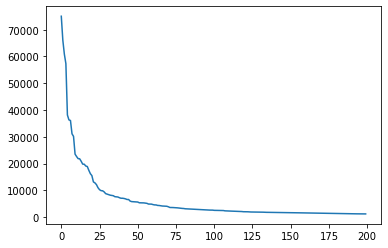

In [12]:
first_200_freqs = [freq for word, freq in freq_dict_sorted[:200]]
plt.plot(first_200_freqs)
plt.show()

In [9]:
high_freq_words = []
mid_freq_words = []
low_freq_words = []

for word, freq in freq_dict_sorted:
  if freq >= 100:
    high_freq_words.append(word)
  elif freq < 100 and freq >= 10:
    mid_freq_words.append(word)
  else: 
    low_freq_words.append(word)

len(high_freq_words), len(mid_freq_words), len(low_freq_words)

(2271, 15743, 165449)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(df.clean_text, df.class_label)

In [15]:
cv = CountVectorizer(vocabulary=high_freq_words, lowercase=False, ngram_range=(1, 1))
bow = cv.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(cv.transform(x_test))
print(classification_report(pred, y_test))

C:\Users\Alina\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.81      0.79      0.80     29518
           1       0.78      0.80      0.79     27191

    accuracy                           0.79     56709
   macro avg       0.79      0.79      0.79     56709
weighted avg       0.79      0.79      0.79     56709



In [16]:
cv = CountVectorizer(vocabulary=mid_freq_words, lowercase=False, ngram_range=(1, 1))
bow = cv.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(cv.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.55      0.67      0.60     23922
           1       0.71      0.60      0.65     32787

    accuracy                           0.63     56709
   macro avg       0.63      0.64      0.63     56709
weighted avg       0.64      0.63      0.63     56709



In [17]:
cv = CountVectorizer(vocabulary=low_freq_words, lowercase=False, ngram_range=(1, 1))
bow = cv.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(cv.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.36      0.66      0.47     15973
           1       0.80      0.55      0.65     40736

    accuracy                           0.58     56709
   macro avg       0.58      0.60      0.56     56709
weighted avg       0.68      0.58      0.60     56709



Судя по результатам работы классификаторов наиболее важны самые частые токены в преобработанном тексте. В необработанном тексте результаты сравнимо плохие. Качество работы классификатора с наиболее частотными токенами напрямую зависит от выбора границ частотности 

## Задание 2.
Найти фичи с наибольшей значимостью, и вывести их

In [18]:
cv = CountVectorizer(lowercase=False, ngram_range=(1, 1))
bow = cv.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(cv.transform(x_test))
print(classification_report(pred, y_test))

C:\Users\Alina\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.82      0.83      0.82     28492
           1       0.83      0.81      0.82     28217

    accuracy                           0.82     56709
   macro avg       0.82      0.82      0.82     56709
weighted avg       0.82      0.82      0.82     56709



In [19]:
# Сшиваем номер коэффициента и коэфццициент важности фичи в список туплов
indexed_coefs = [(i,v) for i,v in enumerate(clf.coef_.flatten())]
# Сортируем список по второму элементу тупла (важности)
indexed_coefs.sort(key=lambda iv: -iv[1])

# Берём из словаря, который составил себе CountVectorizer (слово -> индекс_фичи)
# ключи и значения, и превращаем их в списки, чтобы по ним можно было индексироваться
key_list = list(cv.vocabulary_.keys())
val_list = list(cv.vocabulary_.values())

# Берём первые N фичей из отсортированного по важности списка
for i in range(0, 10):
  # Достаём из списка пару (номер_фичи, важности_фичи)
  iv = indexed_coefs[i]
  # В списке индексов фичей из словаря CountVectorizer'а ищем индекс из пары
  feat_idx = val_list.index(iv[0])
  # Печатаем слово (имя фичи, полученное по её индексу) и его важность
  print(f'{key_list[feat_idx]}: {iv[1]}')

печаль: 9.195251251864088
скептик: 5.969881550753077
снаступающимтвиттерский: 3.9284480785078775
плач: 3.10677805381259
печально: 2.9699246581621135
сожалению: 2.7659306219858175
обидно: 2.6347645427528033
скучать: 2.518542305759075
грустный: 2.492956702733249
заболела: 2.4737917155338276


## Задание 3.
1) сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

2) подобрать оптимальный размер для hashing векторайзера

3) убедиться что для сетки нет переобучения

In [20]:
cv = CountVectorizer(ngram_range=(1, 3), lowercase=False)
bow = cv.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(cv.transform(x_test))
print(classification_report(pred, y_test))

C:\Users\Alina\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.83      0.84      0.84     28571
           1       0.84      0.83      0.83     28138

    accuracy                           0.84     56709
   macro avg       0.84      0.84      0.84     56709
weighted avg       0.84      0.84      0.84     56709



In [21]:
vec = TfidfVectorizer(ngram_range=(1, 3), lowercase=False)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82     27622
           1       0.84      0.80      0.82     29087

    accuracy                           0.82     56709
   macro avg       0.82      0.82      0.82     56709
weighted avg       0.82      0.82      0.82     56709



In [22]:
hash_vec = HashingVectorizer(ngram_range=(2, 5), lowercase=False)
bow = hash_vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(hash_vec.transform(x_test))
print(classification_report(pred, y_test))

C:\Users\Alina\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.80      0.67      0.73     34455
           1       0.59      0.74      0.66     22254

    accuracy                           0.70     56709
   macro avg       0.70      0.71      0.70     56709
weighted avg       0.72      0.70      0.70     56709



In [23]:
hash_vec = HashingVectorizer(ngram_range=(1, 2), lowercase=False)
bow = hash_vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(hash_vec.transform(x_test))
print(classification_report(pred, y_test))

C:\Users\Alina\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.83      0.82      0.83     29379
           1       0.81      0.82      0.82     27330

    accuracy                           0.82     56709
   macro avg       0.82      0.82      0.82     56709
weighted avg       0.82      0.82      0.82     56709



In [24]:
hash_vec = HashingVectorizer(ngram_range=(2, 4), lowercase=False)
bow = hash_vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(hash_vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.81      0.68      0.74     34381
           1       0.60      0.75      0.67     22328

    accuracy                           0.71     56709
   macro avg       0.70      0.71      0.70     56709
weighted avg       0.72      0.71      0.71     56709



In [25]:
hash_vec = HashingVectorizer(ngram_range=(1, 3), lowercase=False)
bow = hash_vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(hash_vec.transform(x_test))
print(classification_report(pred, y_test))

C:\Users\Alina\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.83      0.82      0.83     29419
           1       0.81      0.82      0.82     27290

    accuracy                           0.82     56709
   macro avg       0.82      0.82      0.82     56709
weighted avg       0.82      0.82      0.82     56709



In [11]:
import tensorflow as tf

from keras import Sequential
from keras.layers import Dense, Embedding, GlobalAveragePooling1D, Conv1D, GRU, LSTM, Dropout, TextVectorization


In [12]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
valid_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_data = train_data.batch(32)
valid_data = valid_data.batch(64)

In [13]:
vocab = list(set(high_freq_words + mid_freq_words))
vocab_size = len(vocab)
seq_len = 20

vectorize_layer = TextVectorization(
    standardize=None,
    max_tokens=vocab_size+1,
    output_mode='binary',
    #output_sequence_length=seq_len,
    ngrams=(1, 3),
    vocabulary=vocab)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_data = train_data.map(lambda x, y: x)
# vectorize_layer.adapt(text_data)
vectorize_layer.build(input_shape=(1,))

In [31]:
embedding_dim=64

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=seq_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [22]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [23]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

hh = model.fit(train_data, 
               epochs=5, 
               validation_data=valid_data)

Epoch 1/5
5317/5317 [==============================] - 166s 31ms/step - loss: 0.5564 - accuracy: 0.7445 - val_loss: 0.4501 - val_accuracy: 0.8035
Epoch 2/5
5317/5317 [==============================] - 166s 31ms/step - loss: 0.4241 - accuracy: 0.7978 - val_loss: 0.3944 - val_accuracy: 0.8141
Epoch 3/5
5317/5317 [==============================] - 166s 31ms/step - loss: 0.3846 - accuracy: 0.8176 - val_loss: 0.3768 - val_accuracy: 0.8189
Epoch 4/5
5317/5317 [==============================] - 166s 31ms/step - loss: 0.3639 - accuracy: 0.8302 - val_loss: 0.3690 - val_accuracy: 0.8210
Epoch 5/5
5317/5317 [==============================] - 165s 31ms/step - loss: 0.3506 - accuracy: 0.8391 - val_loss: 0.3654 - val_accuracy: 0.8205


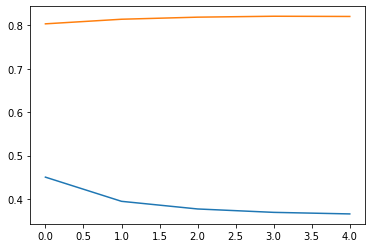

In [24]:
plt.plot(hh.history['val_loss'])
plt.plot(hh.history['val_accuracy'])